# Exercise 2

In [1]:
from pset.algorithms import SGA

def run_simulation():
    """Run SGA simulation of the one-max problem."""
    sim = SGA()
    sim.run()
    mean, std, best = sim.fitness_over_time[:]
    assert(len(mean) == len(best))
    for l in [mean, std, best]:
        while len(l) < 100:
            l.append(l[-1])
    return mean, std, best

/Users/pablotrinidad/Documents/UNAM/Cómputo Evolutivo/cevolutivo/psets/05/pset/algorithms.py:109: RuntimeWarning: invalid value encountered in double_scalars
  i.fps_prob = i.tmp_fitness / pop_total


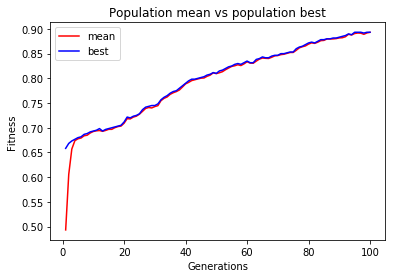

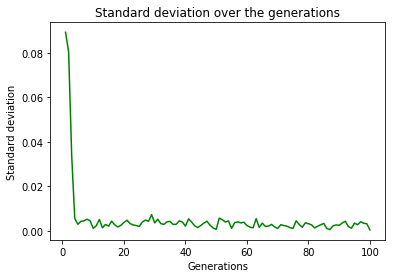

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

def update_list(current, new):
    return map(lambda c, n: c + n, current, new)

mean, std, best = [0]*100, [0]*100, [0]*100
for i in range(20):
    m, s, b = run_simulation()
    mean = update_list(mean, m)
    std = update_list(std, s)
    best = update_list(best, b)
    
X = np.array(range(1, 101))
mean = [x/20 for x in mean]
std = [x/20 for x in std]
best = [x/20 for x in best]

plt.figure('Mean vs best')
plt.title("Population mean vs population best")
mean_plt, = plt.plot(X, mean, 'r', label='mean')
best_plt, = plt.plot(X, best, 'b', label='best')
plt.legend(handles=[mean_plt, best_plt])
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.savefig('./assets/ex2_mean.png')
plt.show()

plt.figure('STD')
plt.title("Standard deviation over the generations")
plt.plot(X, std, 'g')
plt.xlabel('Generations')
plt.ylabel('Standard deviation')
plt.savefig('./assets/ex2_std.png')
plt.show()

# Exercise 3

In [ ]:
from pset.algorithms import SGA

def run_simulation_with_schemas():
    """Run SGA simulation of the one-max problem writing generation's schemas on files."""
    sim = SGA()
    sim.run()
    mean, std, best = sim.fitness_over_time[:]
    assert(len(mean) == len(best))
    for l in [mean, std, best]:
        while len(l) < 100:
            l.append(l[-1])
    return mean, std, best